In [414]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd

In [415]:
# Read Data
spectrum_train = pd.read_excel('spectrum_train.xlsx')
spectrum_test = pd.read_excel('spectrum_valid.xlsx')
temp_train = pd.read_excel('temp_train.xlsx')
temp_test = pd.read_excel('temp_valid.xlsx')

spectrum_train_scaled = spectrum_train.multiply(10**12)
spectrum_test_scaled = spectrum_test.multiply(10**12)

In [416]:
def rename_columns(df):
    new_df = df
    for i in range(len(df.columns)):
        new_df.columns.values[i] = int(i)

    return new_df

In [417]:
# 1 - temp to spectrum
# 0 - spectrum to temp
direction = 1

target_index = 9

X_train = []
X_test = []
y_train = []
y_test = []

if direction:
    X_train = temp_train
    X_test = temp_test
    y_train = rename_columns(spectrum_train_scaled.iloc[:,[target_index]])
    y_test = rename_columns(spectrum_test_scaled.iloc[:,[target_index]])
else:
    X_train = rename_columns(spectrum_train_scaled)
    X_test = rename_columns(spectrum_test_scaled)
    y_train = temp_train.iloc[:,[target_index]]
    y_test = temp_test.iloc[:,[target_index]]

In [418]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [419]:
input_data = df_to_tensor(X_train)
output_data = df_to_tensor(y_train)

In [420]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [421]:
input_size = len(X_train.columns)
output_size = len(y_train.columns)
model = Net(input_size=input_size, output_size=output_size)

In [422]:
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Rprop(model.parameters(), lr=0.001)

In [423]:
num_epochs = 15
batch_size = 20
num_batches = len(input_data) // batch_size

for epoch in range(num_epochs):
    for batch in range(num_batches):
        start = batch * batch_size
        end = start + batch_size

        inputs = input_data[start:end]
        targets = output_data[start:end]

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    # Print the loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

Epoch 1/15, Loss: 21.462322
Epoch 2/15, Loss: 24.195824
Epoch 3/15, Loss: 11.647438
Epoch 4/15, Loss: 4.618194
Epoch 5/15, Loss: 26.076046
Epoch 6/15, Loss: 7.964769
Epoch 7/15, Loss: 0.993376
Epoch 8/15, Loss: 2.256296
Epoch 9/15, Loss: 0.484914
Epoch 10/15, Loss: 0.295830
Epoch 11/15, Loss: 2.330442
Epoch 12/15, Loss: 0.281132
Epoch 13/15, Loss: 0.603378
Epoch 14/15, Loss: 0.849287
Epoch 15/15, Loss: 0.209403


In [424]:
pred = model(df_to_tensor(X_test))
pred = pd.DataFrame(pred.detach().numpy())

actual = y_test

In [425]:
pred

,0
0,13.453341
1,11.585672
2,13.477182
3,10.979799
4,13.636612
...,...
187,10.453387
188,12.841932
189,11.203888
190,12.745985


In [426]:
actual

,0.0
0,3.790090
1,3.043688
2,4.007671
3,2.884035
4,4.022686
...,...
187,3.141284
188,4.500144
189,3.654108
190,4.746312


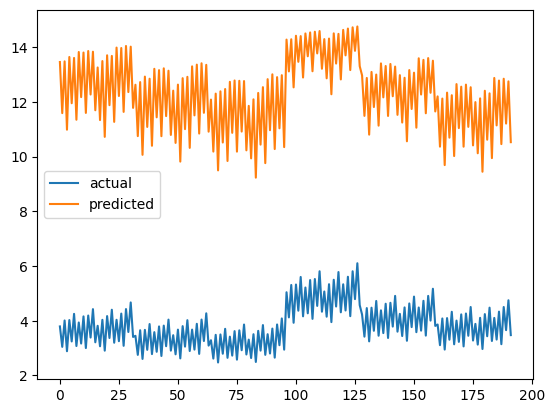

In [427]:
import matplotlib.pyplot as plt

plt.plot(range(192), actual.values, label='actual')
plt.plot(range(192), pred.values, label='predicted')
plt.legend()
plt.show()

In [428]:
diff = pred.subtract(actual).mean()

In [429]:
diff

0    8.466531
dtype: float64

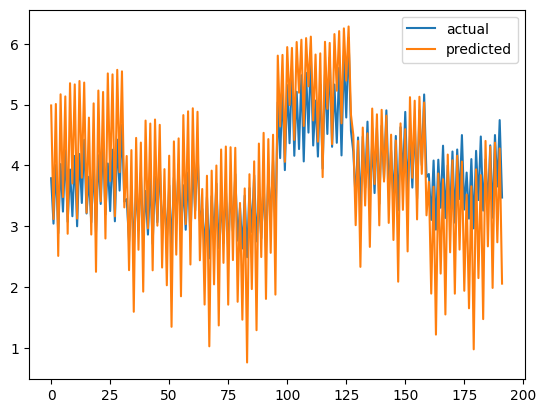

In [430]:
import matplotlib.pyplot as plt

plt.plot(range(192), actual.values, label='actual')
plt.plot(range(192), pred.subtract(diff).values, label='predicted')
plt.legend()
plt.show()